In [1]:
import numpy as np
import pyCloudy as pc
import matplotlib.pyplot as plt
import pandas as pd

from astropy.io import fits
from astropy.wcs import WCS
from astropy.utils.data import get_pkg_data_filename
from PIL import Image

In [2]:
## Funciones para clasificar las regiones SF, TO y AGN
def flag_kau (x,y):
    sfg_flag_kau = np.zeros(np.shape(x))
    y_kau_us = np.zeros(np.shape(x))
    #Regiones de Formación estelar (abajo de kuffmann) 
    for i in range(len(x)):
        y_kau_us[i] = np.divide(0.61,y[i]-0.05)+1.3 #Función de Kuffmann
        if x[i] <= y_kau_us[i] and y[i]<= 0.05:
            sfg_flag_kau[i] = 1.0
        else:
            sfg_flag_kau[i] = -9999.00
    
    return sfg_flag_kau

def flag_kew(x,y):
    sfg_flag_kew = np.zeros(np.shape(x))
    y_kew_us = np.zeros(np.shape(x))
    #Regiones bajo Kewley
    for i in range(len(x)):
        y_kew_us[i] = np.divide(0.61,y[i]-0.47)+1.19 #Función de Kewley
        if x[i] <= y_kew_us[i] and y[i] <= 0.47:
            sfg_flag_kew[i] = 1.0
        else:
            sfg_flag_kew[i] = -9999.00
    
    return sfg_flag_kew

In [3]:
# Funcion para divide las regiones SF, TO y AGN
def div(l_x,l_y,x,y):
    
    #Hacemos los flageos el diagrama BPT y las funciones de Kuffmann y Kewley
    sfg_flag_kau =  flag_kau (l_x,l_y)
    sfg_flag_kew =  flag_kew (l_x,l_y)
    
    #Regiones de Formacion estelar (abajo de kuffmann)
    rest01 = x[np.where(sfg_flag_kau == 1.0)]
    log_rest01 = y[np.where(sfg_flag_kau == 1.0)]

    #Región entre kuffmann y Kewley (TO's)
    doublet01 = np.logical_and(sfg_flag_kew == 1.0, sfg_flag_kau != 1.0)
    rest02 = x[np.where(doublet01)]
    log_rest02 = y[np.where(doublet01)]

    #Regiones de AGN (arriba de Kewley)
    rest03 = x[np.where(sfg_flag_kew != 1.0)]
    log_rest03 = y[np.where(sfg_flag_kew != 1.0)]
    
    return [rest01,log_rest01,rest02,log_rest02,rest03,log_rest03]

In [4]:
## Cargamos el archivo fits 
filename = get_pkg_data_filename('/home/echeveste/Downloads/nsa_v0_1_2.fits')
linea = fits.open(filename)[1].data

In [5]:
cond = ( (linea['N2FLUX'] != 0.) & (linea['HAFLUX'] != 0.) & 
         (linea['O3FLUX'] != 0.) & (linea['HBFLUX'] != 0.))

In [6]:
N2FLUX = linea['N2FLUX'][cond]
O3FLUX = linea['O3FLUX'][cond]
HAFLUX = linea['HAFLUX'][cond]
HBFLUX = linea['HBFLUX'][cond]

In [7]:
l_NII_6584 = np.log10(N2FLUX / HAFLUX)
l_OIII_5007 = np.log10(O3FLUX / HBFLUX)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/usr/lib/python3/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [8]:
## Dividimos las regiones SF's, TO's y AGN
rest_O3HbN2Ha = div(l_OIII_5007,l_NII_6584,l_OIII_5007, l_NII_6584)

In [9]:
## Funciones de Kuffmann y Kewley
x_NII_6584_1 = np.arange(-2.0,0.0,0.0001) #Para linea de Kuffmann
x_NII_6584_2 = np.arange(-2.0,0.4,0.0001) #Para liena de Kewley 
line_kuf = np.divide(0.61,x_NII_6584_1-0.05)+1.3
line_kew = np.divide(0.61,x_NII_6584_2-0.47)+1.19

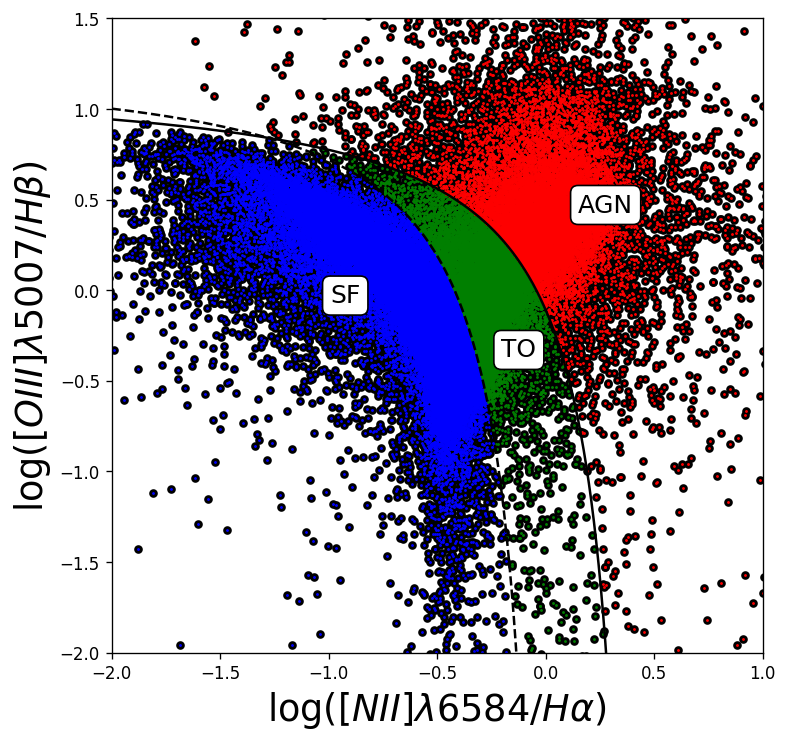

In [12]:
fig, ax  = plt.subplots(figsize=(7,7), dpi=120)
ax.scatter(np.array(l_NII_6584),np.array(l_OIII_5007), s=10, c='k', marker='o', lw=2)
ax.scatter(rest_O3HbN2Ha[1],rest_O3HbN2Ha[0], s=2, c='b', marker='.')
ax.scatter(rest_O3HbN2Ha[3],rest_O3HbN2Ha[2], s=2, c='g', marker='.')
ax.scatter(rest_O3HbN2Ha[5],rest_O3HbN2Ha[4], s=2, c='r', marker='.')

## Graficamos las lineas de Kuffmann y Kewley
ax.plot(x_NII_6584_2,line_kew,'k-')
ax.plot(x_NII_6584_1,line_kuf,'k--')

ax.axes.set_xlim(-2.0,1.0)
ax.axes.set_ylim(-2.0,1.5)
ax.axes.set_ylabel('$\log([OIII]\lambda5007/H \\beta )$',fontsize = 22)
ax.axes.set_xlabel('$\log([NII]\lambda6584/H \\alpha )$',fontsize = 22)


ax.annotate("SF",fontsize = 15, xy=(-1, 0.3),  xycoords='data',
            bbox=dict(boxstyle="round", fc="w", ec="k"),
            xytext=(10, -40), textcoords='offset points', ha='center')
ax.annotate("TO",fontsize = 15, xy=(-0.2, -0.),  xycoords='data',
            bbox=dict(boxstyle="round", fc="w", ec="k"),
            xytext=(10, -40), textcoords='offset points', ha='center')
ax.annotate("AGN",fontsize = 15, xy=(0.2, 0.8),  xycoords='data',
            bbox=dict(boxstyle="round", fc="w", ec="k"),
            xytext=(10, -40), textcoords='offset points', ha='center')
plt.savefig("img_grf/NASA_BPT.jpg")